In [36]:
import pandas as pd
import imp

import sklearn
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt

from main import find_index, carry_out_recursive_feature_elimination

In [37]:
parameters = imp.load_source("parameters", "../../../data/raw/parameters.py")

In [38]:
def dx(x, t, S):
    """
    Define the derivative of x.
    """
    f = S @ x
    phi = f @ x
    return x * (f - phi)


N = len(parameters.PLAYER_GROUPS["full"])

df = pd.read_csv(
    "../../../data/processed/full/std/per_opponent/main.csv"
)
array = np.zeros((N, N))
for pair, score in df.groupby(["Player index", "Opponent index"])[
    "Score"
]:
    array[pair] = score / (parameters.TURNS * parameters.REPETITIONS)
    if pair[0] == pair[1]:
        array[pair] /= 2


ts = np.linspace(0, 10, 2 * 10 ** 2)
x0 = np.array([1 / N for _ in range(N)])
xs = odeint(func=dx, y0=x0, t=ts, args=(array,))

aggregate_df = df.groupby("Player index").agg(["mean", "median", "std", "max", "min", "var"])
aggregate_df["s_i"] = xs[-1]

In [39]:
Y = aggregate_df["s_i"]
X = aggregate_df[["residual", "chi"]]

In [40]:
Y.head()

Player index
0    5.024829e-07
1    9.031990e-03
2    4.916657e-08
3    9.100225e-03
4    2.808890e-05
Name: s_i, dtype: float64

In [41]:
X.head()

residual                                                        \
                  mean    median       std       max           min       var   
Player index                                                                   
0             0.083834  0.062500  0.097969  0.529421  4.962440e-07  0.009598   
1             0.776823  1.235294  0.551097  1.235294  0.000000e+00  0.303708   
2             0.162841  0.058824  0.255963  1.100579  2.765522e-04  0.065517   
3             0.772692  1.234177  0.548465  1.234177  0.000000e+00  0.300813   
4             0.050754  0.031634  0.094281  0.490000  0.000000e+00  0.008889   

                    chi                                              \
                   mean     median        std        max        min   
Player index                                                          
0             -2.742235  -1.000000  11.674660  20.219352 -26.309607   
1              0.711349   0.062500   1.715759  15.749016  -2.892567   
2              0.549887  -2.888889   6.623267  15.982968  -7.190259   
3              0.729207   0.063331   1.714565  15.749016  -2.892567   
4             13.583206  16.000000   5.790799  16.000000  -1.000000   

                          
                     var  
Player index              
0             136.297691  
1               2.943830  
2              43.867664  
3               2.939735  
4              33.533355

Confirm the model currently in the manuscript:

In [44]:
model = sm.OLS(Y, sm.add_constant(X["residual"]["var"])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_i   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     158.8
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           3.00e-27
Time:                        16:03:35   Log-Likelihood:                 863.55
No. Observations:                 204   AIC:                            -1723.
Df Residuals:                     202   BIC:                            -1716.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -0.993      0.322      -0.001       0.000
var            0.0281      0.002     12.603      0.000       0.024       0.032
==============================================================================
Omnibus:                        3.553   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.340
Skew:                           0.204   Prob(JB):                        0.188
Kurtosis:                       3.476   Cond. No.                         9.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Use sklearn's recursive feature elimination to find "best" linear model.

A plot of AIC and BIC:

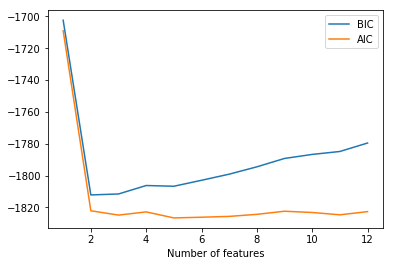

In [26]:
number_of_features = range(1, len(X.columns) + 1)
aics = [carry_out_recursive_feature_elimination(n_features_to_select=i, X=X, Y=Y).aic
        for i in number_of_features]
bics = [carry_out_recursive_feature_elimination(n_features_to_select=i, X=X, Y=Y).bic
        for i in number_of_features]
plt.figure()
plt.plot(number_of_features, bics, label="BIC")
plt.plot(number_of_features, aics, label="AIC")
plt.legend()
plt.xlabel("Number of features");

2 looks like the correct number of features.

In [27]:
model = carry_out_recursive_feature_elimination(n_features_to_select=2, X=X, Y=Y)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_i   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     194.1
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           1.16e-47
Time:                        15:54:00   Log-Likelihood:                 914.07
No. Observations:                 204   AIC:                            -1822.
Df Residuals:                     201   BIC:                            -1812.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0013      0.000      3.104      0.002       0.000       0.002
('residual', 'mean')      -0.0149      0.001    -12.346      0.000      -0.017      -0.012
('residual', 'median')     0.0155      0.001     17.818      0.000       0.014       0.017
==============================================================================
Omnibus:                        8.044   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               11.470
Skew:                           0.233   Prob(JB):                      0.00323
Kurtosis:                       4.064   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mean SSerror reduces fixation, median increases it. This strategies with long tail (positive skew) distributions (giving a large mean and a low median) have a low fixation whereas strategies with a negative skew will be more likely to become fixed. This implies that strategies that usually don't act in a ZD way but can adapt to do so will behave well in an evolutionary setting.

Let us double check that RSE is working properly using brute force.

In [28]:
import itertools

def iterate_over_all_variables(number_of_features=2):
    for variables in itertools.product(X.columns, repeat=number_of_features):
        x = sm.add_constant(X[list(variables)])
        model = sm.OLS(Y, x).fit()
        yield variables, model.rsquared

In [29]:
max(iterate_over_all_variables(number_of_features=2), key=lambda x: x[1])

((('residual', 'mean'), ('residual', 'median')), 0.6588317301092173)

In [31]:
max(iterate_over_all_variables(number_of_features=3), key=lambda x: x[1])

((('residual', 'mean'), ('residual', 'median'), ('residual', 'min')),
 0.672366803762088)

In [35]:
model = carry_out_recursive_feature_elimination(n_features_to_select=3, X=X, Y=Y)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    s_i   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     133.3
Date:                Mon, 19 Nov 2018   Prob (F-statistic):           1.82e-47
Time:                        15:57:29   Log-Likelihood:                 916.43
No. Observations:                 204   AIC:                            -1825.
Df Residuals:                     200   BIC:                            -1812.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0007      0.001      1.351      0.178      -0.000       0.002
('residual', 'mean')      -0.0131      0.001     -9.054      0.000      -0.016      -0.010
('residual', 'median')     0.0136      0.001     11.172      0.000       0.011       0.016
('residual', 'var')        0.0056      0.003      2.163      0.032       0.000       0.011
==============================================================================
Omnibus:                       13.613   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.684
Skew:                           0.383   Prob(JB):                     1.96e-05
Kurtosis:                       4.401   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""